# Taxi Fare Predict With Bigquery ML

### (Data Analysis and Machine Learning)

A client is interested in building an app to estimate how much a ride will cost for every users.

As a Data Engineer, we can take several steps to meet client needs : import and analyze New York Taxi datasets (as our training datasets), clean the data, then build a basic model and perform fares predictions based on information available when a new trip starts.

### 1. Loading Packages

Import library needed for analysis and visualization.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from geopy.distance import great_circle as GRC

### 2. Create Connection To BigQuery

Because the New York Taxi dataset is available on BigQuery, so we have to accessing BigQuery.

Set the environment variables containing the location of JSON file to make connection to BigQuery.

In [2]:
warnings.filterwarnings('ignore')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/Rakyan Prajnagra/Documents/Data Engineer/BigQuery-Taxi-Fare-Prediction-Project/qwiklabs-gcp-02-34d67b271e82-349e9f9b2ca1.json'

Execute the query below to use %%bigquery magic command. This command is used to run a SQL query and return the results as a Pandas Dataframe.

In [3]:
%load_ext google.cloud.bigquery

### 3. Exploring Data

The client provides taxi trip data (in csv format) which we will predict later. The client data stored in Cloud Storage. Loading this csv data to BigQuery table `client_prediction_data`.

In [4]:
%%bigquery
LOAD DATA OVERWRITE taxirides.client_prediction_data
FROM FILES (
  format = 'CSV',
  uris = ['gs://ml-fare-predictions/client_prediction_data.csv'])

Query is running:   0%|          |

""


Now we can check the schema of the `client_prediction_data` table.

In [5]:
%%bigquery
SELECT column_name, data_type
FROM `taxirides.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'client_prediction_data'
ORDER BY ordinal_position

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type
0,pickup_datetime,TIMESTAMP
1,pickuplon,FLOAT64
2,pickuplat,FLOAT64
3,dropofflon,FLOAT64
4,dropofflat,FLOAT64
5,passengers,INT64


`client_prediction_data` table tell us about when the trip start, where are the coordinates of the pickup and dropoff, and how many passenger on the trip. Focus on this 6 columns as our guide to create a model.

But before creating a model, we have to prepare our training data first. We use New York Taxi dataset as a training data. Let's have a look at New York Taxi dataset.

In [4]:
%%bigquery
SELECT column_name, data_type
FROM `taxirides.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = 'historical_taxi_rides_raw'
ORDER BY ordinal_position

Query is running:   0%|          |

Downloading:   0%|          |

,column_name,data_type
0,vendor_id,STRING
1,pickup_datetime,TIMESTAMP
2,dropoff_datetime,TIMESTAMP
3,pickup_longitude,FLOAT64
4,pickup_latitude,FLOAT64
5,dropoff_longitude,FLOAT64
6,dropoff_latitude,FLOAT64
7,rate_code,STRING
8,passenger_count,INT64
9,trip_distance,FLOAT64


Here is the description of the variables in datasets.
1. vendor_id -> A code indicating the taxi provider

2. pickup_datetime -> Date and time when the meter was engaged

3. dropoff_datetime -> Date and time when the meter was disengaged

4. pickup_longitude -> The longitude where the meter was engaged

5. pickup_latitude -> The latitude where the meter was engaged

6. dropoff_longitude -> The longitude where the meter was disengaged 

7. dropoff_longitude -> The latitude where the meter was disengaged

8. rate_code -> The final rate code in effect at the end of the trip

9. passenger_count -> The number of passengers in the vehicle

10. trip_distance -> The elapsed trip distance in miles reported by the taximeter

11. payment_type -> A code signifying how the passenger paid for the trip\
    (1=Credit Card; 2=Cash; 3=No Charge; 4=Dispute; 5=Unknown; 6=Voided Trip)

12. fare_amount -> The time and distance fare calculated by the meter 

13. extra -> Miscellaneous extras and surcharges

14. mta_tax -> $0.50 MTA tax that is automatically triggered based on the meteredrate in use

15. imp_surcharge -> $0.30 improvement surcharge assessed trips at the flag drop

16. tip_amount -> Tip amount (populated for credit card tips only)

17. tolls_amount -> Total amount of all tolls paid in trip

18. total_amount -> The total amount charged to passengers (Do not include cash tips)

19. store_and_fwd_flag -> Indicates whether the trip record was held in vehicle memory before sending to the vendor\
    (Y=Store and forward trip; N=Not a store and forward trip)

Now, import the dataset into pandas dataframe so that data can be analyzed.

In [5]:
%%bigquery raw 
SELECT * FROM `taxirides.historical_taxi_rides_raw`
LIMIT 10000000

Query is running:   0%|          |

Downloading:   0%|          |

Exploring data can be done using statistical and visualization techniques. Check for the statistical details of the data.

In [6]:
raw.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,extra,mta_tax,imp_surcharge,tip_amount,tolls_amount,total_amount
count,1.000000e+07,1.000000e+07,9.999943e+06,9.999943e+06,10000000.0,1.000000e+07,1.000000e+07,1.000000e+07,9.115403e+06,0.0,1.000000e+07,1.000000e+07,1.000000e+07
mean,-7.247927e+01,3.989293e+01,-7.246564e+01,3.988230e+01,1.685491,3.226885e+00,9.175739e+00,3.078235e-01,4.975501e-01,NaN,9.123680e-01,1.137485e-01,1.096473e+01
std,1.232864e+01,8.894253e+00,1.203039e+01,8.958733e+00,1.340927,2.722611e+03,7.158749e+00,3.622728e-01,4.122837e-02,NaN,1.629694e+00,8.114584e-01,8.528792e+00
min,-3.395886e+03,-3.475475e+03,-3.049155e+03,-3.478280e+03,0.0,0.000000e+00,-7.500000e+01,-1.000000e+00,-1.000000e+00,NaN,-4.150000e+01,-8.000000e+00,-7.500000e+01
25%,-7.399192e+01,4.073663e+01,-7.399145e+01,4.073647e+01,1.0,9.000000e-01,5.500000e+00,0.000000e+00,5.000000e-01,NaN,0.000000e+00,0.000000e+00,7.000000e+00
50%,-7.398190e+01,4.075296e+01,-7.398074e+01,4.075352e+01,1.0,1.420000e+00,7.500000e+00,0.000000e+00,5.000000e-01,NaN,0.000000e+00,0.000000e+00,9.000000e+00
75%,-7.396815e+01,4.076677e+01,-7.396649e+01,4.076767e+01,2.0,2.200000e+00,1.000000e+01,5.000000e-01,5.000000e-01,NaN,1.500000e+00,0.000000e+00,1.190000e+01
max,3.456211e+03,3.338870e+03,3.454826e+03,3.577127e+03,208.0,8.000005e+06,5.000000e+02,1.400000e+01,3.172000e+01,NaN,5.586200e+02,5.151000e+02,5.631200e+02


A few key observations on the New York Taxi dataset:

- There are missing data in numerical column
- The minimum number of passengers is 0 and maximum number of passenger is 208
- The minimum distance of the trip is 0 (no moving) and maximum distance is 5 Million Miles
- Some of the total amount of the trips are under $0

From the results of the observations, we identified anomalies that can affect the model that will be build later. Let us go deeper to find inconsistent or incomplete data.

### 4. Univariate Analysis

The univariate analysis study the patterns of the variables individually. We want to look at the distribution of various variables in New York Taxi dataset. 

#### Trip Distance

Start by analyzing the trip distance. 

Text(0, 0.5, 'Frequency')

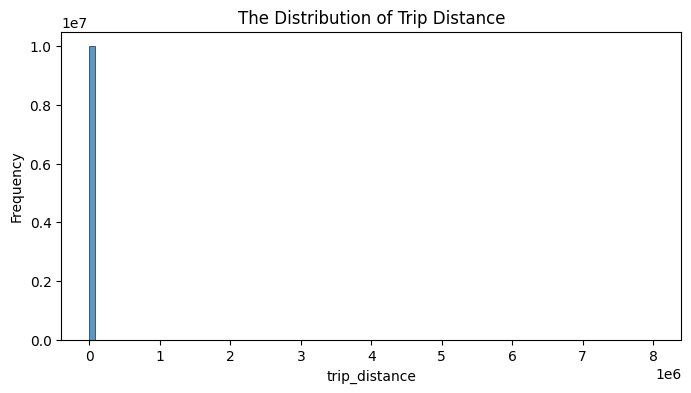

In [7]:
plt.figure(figsize = (8, 4))
sns.histplot(raw['trip_distance'], kde = False, bins = 100)
plt.title('The Distribution of Trip Distance')
plt.xlabel('trip_distance')
plt.ylabel('Frequency')

The histogram shows extremely right skewed data.

Let see to the boxplot of the trip distance.

[Text(0.5, 1.0, 'A Boxplot Depiciting Trip Distance Distribution')]

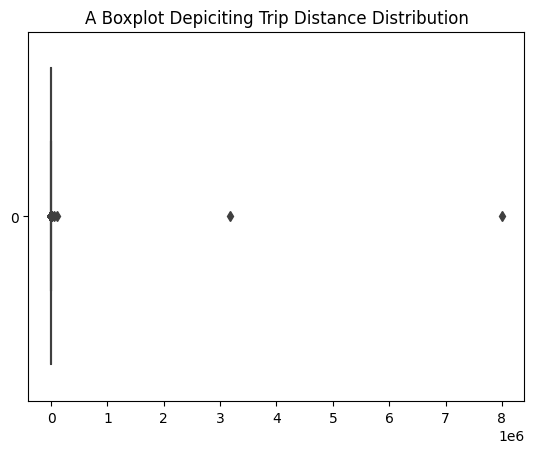

In [8]:
sns.boxplot(raw['trip_distance'], orient = 'horizotal').set(title = 'A Boxplot Depiciting Trip Distance Distribution')

Clearly we see an outlier. There are trip with a distance of around millions of miles (look unreal) while the other are somewhere near zero miles.

#### Fare Amount

Text(0, 0.5, 'Frequency')

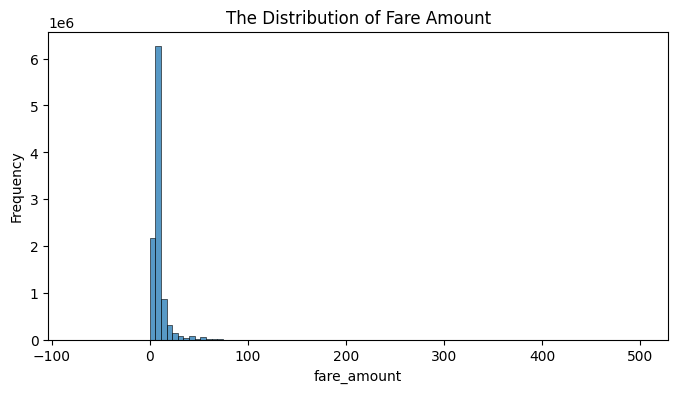

In [9]:
plt.figure(figsize = (8, 4))
sns.histplot(raw['fare_amount'], kde = False, bins = 100)
plt.title('The Distribution of Fare Amount')
plt.xlabel('fare_amount')
plt.ylabel('Frequency')

The most common fare amount are small (under $25), indicating they have a short trips within New York.

[Text(0.5, 1.0, 'A Boxplot Depiciting Fare Amount Distribution')]

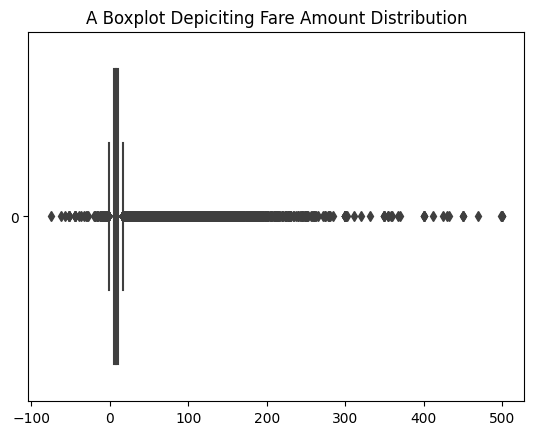

In [10]:
sns.boxplot(raw['fare_amount'], orient = 'horizotal').set(title = 'A Boxplot Depiciting Fare Amount Distribution')

From the boxplot we can see the minimum fare amount is negative, but the initial taxi fare charge is $2,5. So we are going to remove fare amount smaller than $2.5.

#### Passenger Count

Text(0, 0.5, 'Frequency')

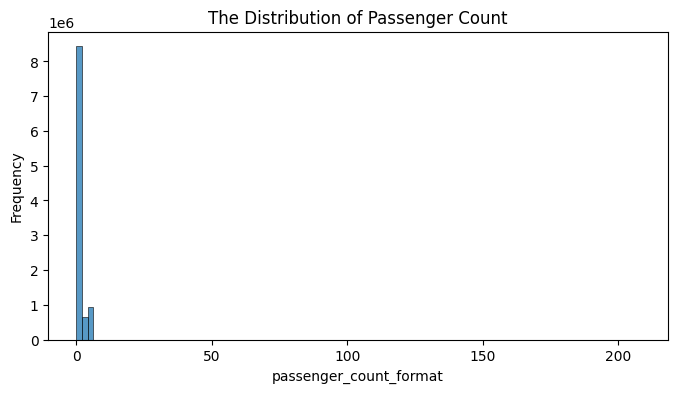

In [11]:
raw['passenger_count_format'] = raw['passenger_count'].astype(int)
plt.figure(figsize = (8, 4))
sns.histplot(raw['passenger_count_format'], kde = False, bins = 100)
plt.title('The Distribution of Passenger Count')
plt.xlabel('passenger_count_format')
plt.ylabel('Frequency')

It often happens that small groups of people travel togther.

In [12]:
print(raw['passenger_count'].value_counts())

passenger_count
1      6990712
2      1418698
5       666786
3       429431
6       262046
4       207529
0        24780
208         10
7            4
9            3
49           1
Name: count, dtype: Int64


- There are some trips with 0 passenger
- Th number of trips with 7 and 9 passengers has a low frequency
- There can't be over than hundreds people in the taxi

From the observation above, we can remove the the row where the number of passengers is less than 1 and more than 6.

#### Store and Forward Flag

In [13]:
raw['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    4484681
0     284728
Y      94798
1       4878
,         38
           3
Name: count, dtype: int64

Almost 2% of trips that were stored before forwading.

From the dataset description earlier, the store and forward flag is only indicated by Y and N. So for the other value must be removed.

#### Latitude

Check the distribution of the pickup and dropoff latitude.

<bound method Figure.tight_layout of <Figure size 1200x500 with 2 Axes>>

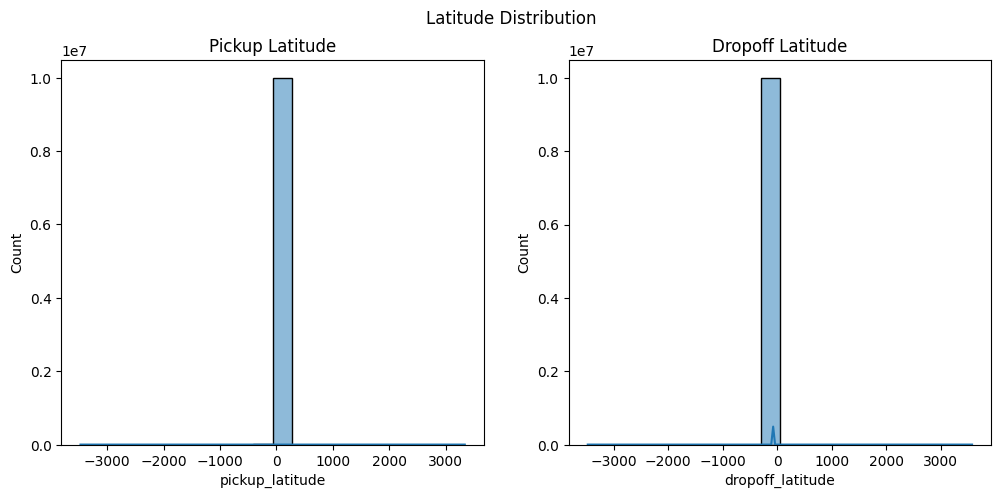

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Latitude Distribution')
sns.histplot(x = raw['pickup_latitude'], ax = ax[0], bins = 20, kde = True).set(title = 'Pickup Latitude')
sns.histplot(x = raw['dropoff_latitude'], ax = ax[1], bins = 20, kde = True).set(title = 'Dropoff Latitude')
fig.tight_layout

The pickup latitude and the dropoff latitude has almost the same kind of distribution. Because of the New York latitude is from 40° 29' 40" N to 45° 0' 42" N, anything outside that value is not necessary.

#### Longitude

Check the distribution of the pickup and dropoff longitude.

<bound method Figure.tight_layout of <Figure size 1200x500 with 2 Axes>>

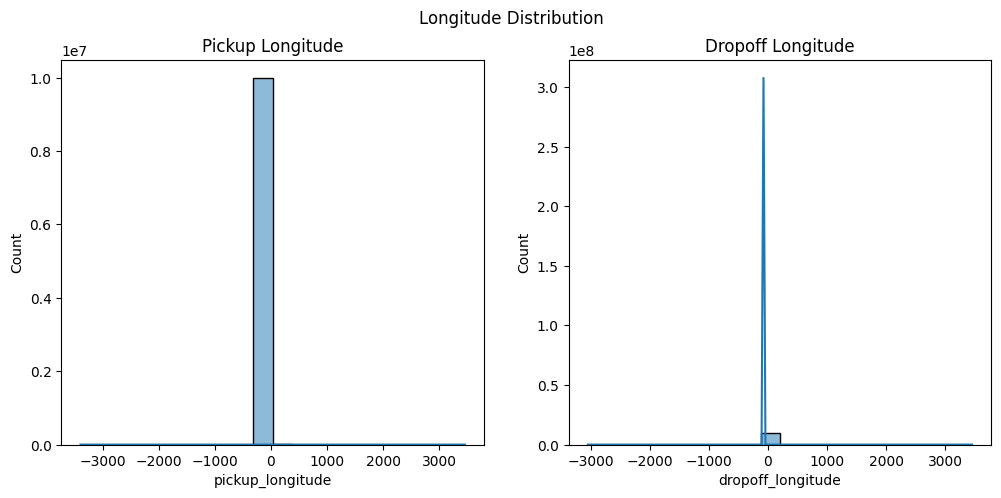

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Longitude Distribution')
sns.histplot(x = raw['pickup_longitude'], ax = ax[0], bins = 20, kde = True).set(title = 'Pickup Longitude')
sns.histplot(x = raw['dropoff_longitude'], ax = ax[1], bins = 20, kde = True).set(title = 'Dropoff Longitude')
fig.tight_layout

Pickup and dropoff longitude has a slightly different distribution. Because of the New York longitude is from 71° 47' 25" W to 79° 45' 54" W, anything outside that value is not necessary.

### 4. Cleaning Training Data

Cleaning data is a process to fixing our training data according to the analysis that we had before. We will clean the New York Taxi dataset and make a copy to the new table `taxi_training_data` using SQL query : 
- Filter the trip_distance value to be more than 0 miles
- Remove rows where fare_amount is very small (less than $2.5)
- Ensure that the latitudes and longitudes are between the New York coordinates
- Make a passenger_count between 1 and 6
- Ensure the store and forward flag is only contains Y and N values
- Create a new column `fare_amount_total` as a result of the addition of `fare_amount` and `tolls_amount` (since the `total_amount` is includes tips amount)
- Because the source dataset is > 10 million rows, sample the dataset to less than 1 million rows

In [16]:
%%bigquery
CREATE OR REPLACE TABLE `taxirides.taxi_training_data`
AS(
    SELECT
        pickup_datetime,
        pickup_latitude AS pickuplat,
        pickup_longitude AS pickuplon,
        dropoff_latitude AS dropofflat,
        dropoff_longitude dropofflon,
        CAST(passenger_count AS INT) AS passengers,
        (tolls_amount + fare_amount) AS fare_amount_total
    FROM `taxirides.historical_taxi_rides_raw`
    WHERE 
        RAND() < 0.001 AND
        (trip_distance > 0) AND
        (fare_amount >= 2.5) AND
        (passenger_count >= 1) AND (passenger_count < 7) AND
        ((store_and_fwd_flag = 'Y') OR (store_and_fwd_flag = 'N')) AND
        (pickup_latitude > 40) AND (pickup_latitude < 45) AND
        (pickup_longitude > -79) AND (pickup_longitude < -71) AND
        (dropoff_latitude > 40) AND (dropoff_latitude < 45) AND
        (dropoff_longitude > -79) AND (dropoff_longitude < -71)
)

Query is running:   0%|          |

""


From now we use this new table as our training dataset.

### 5. Bivariate Analysis

In order to formulate a model, the most important part of building accurate taxi fare prediction model is selecting the feature and target. To identify the feature and target, we have to understand the data first. Check whether the information of the features are correlated with the target.

In this case, the target for our model is `fare_amount_total`

Import our training data that has been cleaned before into pandas dataframe so that data can be analyzed.

In [17]:
%%bigquery biv_an
SELECT * FROM `taxirides.taxi_training_data`

Query is running:   0%|          |

Downloading:   0%|          |

Then we check the statistical summary again.

In [65]:
biv_an.describe()

,pickuplat,pickuplon,dropofflat,dropofflon,passengers,fare_amount_total
count,431968.000000,431968.000000,431968.000000,431968.000000,431968.0,431968.000000
mean,40.750920,-73.976397,40.751215,-73.974936,1.297541,11.188045
std,0.027879,0.033142,0.032044,0.035003,0.654475,9.224470
min,40.160546,-75.705417,40.157223,-77.742713,1.0,2.500000
25%,40.736562,-73.992471,40.735375,-73.991706,1.0,6.000000
50%,40.753072,-73.982253,40.753750,-73.980752,1.0,8.500000
75%,40.767208,-73.968794,40.768223,-73.965801,1.0,12.500000
max,44.871943,-72.091106,44.871943,-71.232033,6.0,300.000000


Looks much better.

#### The Relationship of The Distance and Fare Amount

We have coordinates value (longitude and langitude for pickup and dropoff) in our training dataset. We can use these coordinates to get distance value to used as a feature.

Calculate the distance using Great Circle function (unit distance : Kilometer)

In [18]:
biv_an['distance'] = biv_an.apply(lambda x: GRC((x['pickuplat'], x['pickuplon']),(x['dropofflat'], x['dropofflon'])).km,axis=1)

After creating a distance variable let see what the distance look like.

Text(0, 0.5, 'Frequency')

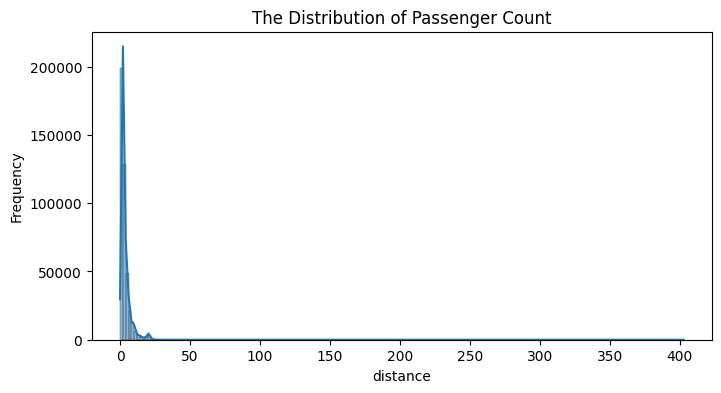

In [19]:
plt.figure(figsize = (8, 4))
sns.histplot(biv_an['distance'], kde = True, bins = 200)
plt.title('The Distribution of Passenger Count')
plt.xlabel('distance')
plt.ylabel('Frequency')

Most of the taxi trip cover fairly short distances.

Now we can check whether the total fare amount have a linear relationship with trip distance.

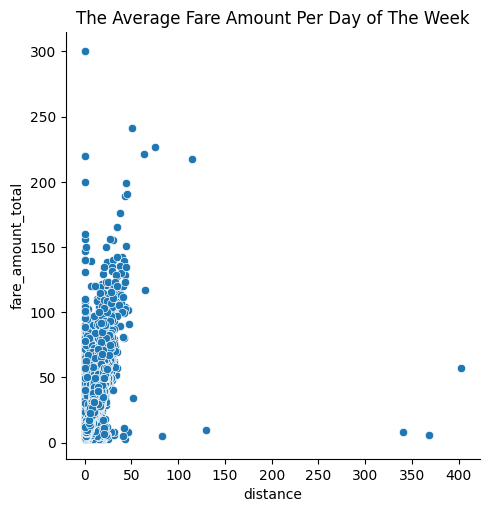

In [20]:
sns.relplot(x = "distance", y = "fare_amount_total", data = biv_an).set(title = 'The Average Fare Amount Per Day of The Week')

We can see there can be a big difference in fare amount for short distance trip, which could happened because the trip use a highway so the fare amount will be expensive, since the `fare_amount_total` is not only for the base fare amount but also including tolls amount. There is a correlation between distance and total fare amount so we can use distance as our first feature.

#### The Relationship of Fare Amount per Day of The Week



We need to extract the day (Monday to Sunday) from the `pickup_datetime` value.

In [76]:
biv_an['day'] = biv_an['pickup_datetime'].dt.day_name()

Check the distribution of the pickup grouped by day.

Text(0, 0.5, 'Frequency')

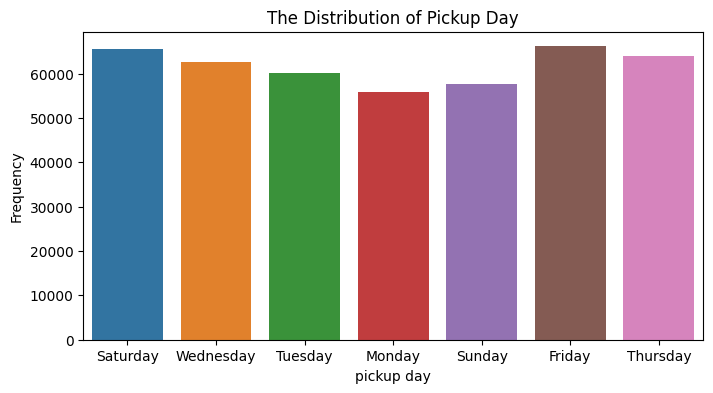

In [77]:
plt.figure(figsize = (8, 4))
sns.countplot(x = biv_an['day'])
plt.title('The Distribution of Pickup Day')
plt.xlabel('pickup day')
plt.ylabel('Frequency')

Many people use taxi on Friday and Saturday.

The correlation between pickup day and fare amount can be seen from the cart below.

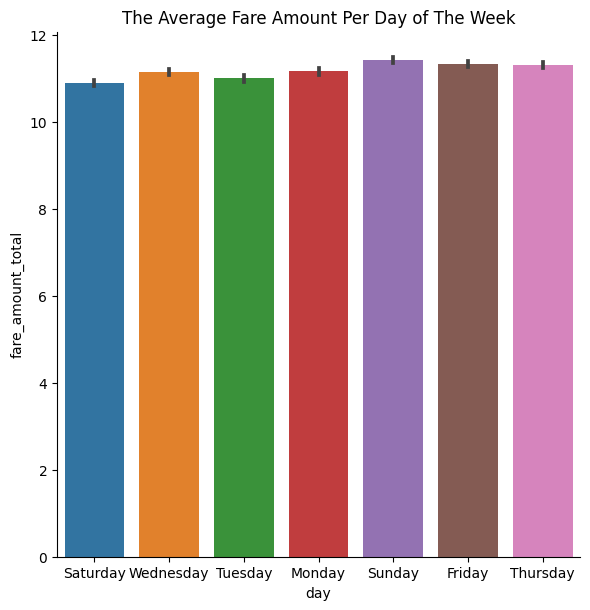

In [78]:
sns.catplot(x="day", y = "fare_amount_total", kind = "bar", data = biv_an, height = 6, aspect = 1).set(title = 'The Average Fare Amount Per Day of The Week')

There is no much difference in the number of fare amount if grouped by the day. But Sunday has the highest average fare amount compared to other day, probably because it's weekend.

#### The Relationship of Fare Amount per Hour of The Day



We need to extract the hour (0 to 23) from the `pickup_datetime` value.

In [73]:
biv_an['hour'] = biv_an['pickup_datetime'].dt.hour

Check the distribution of the pickup grouped by hour.

Text(0, 0.5, 'Frequency')

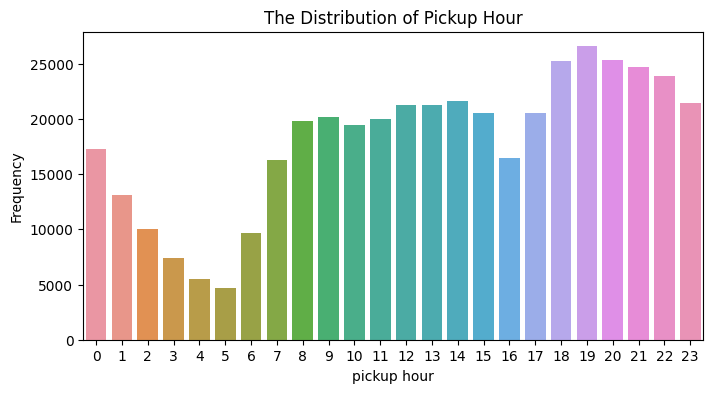

In [75]:
plt.figure(figsize = (8, 4))
sns.countplot(x = biv_an['hour'])
plt.title('The Distribution of Pickup Hour')
plt.xlabel('pickup hour')
plt.ylabel('Frequency')

We see the busiest hours are 6pm to 8pm and that makes sense as this is the time when people return from their offices.

Time to find the correlation between the pickup hour and fare amount.

[Text(0.5, 1.0, 'The Average Fare Amount Per Hour of The Day')]

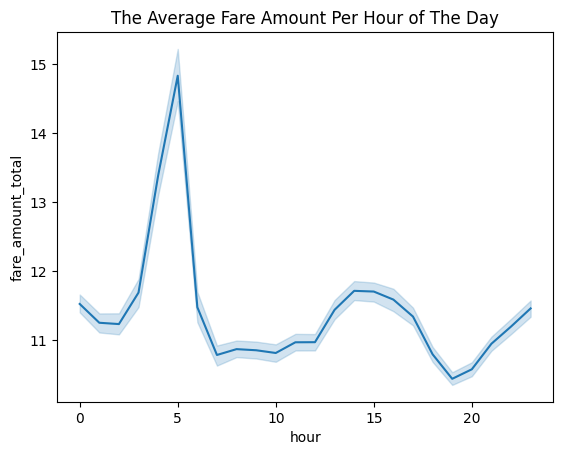

In [67]:
sns.lineplot(x="hour", y = "fare_amount_total", data = biv_an).set(title = 'The Average Fare Amount Per Hour of The Day')

The highest fare amount is in the morning. This can probably point to long distance trips where people start early for the day. 

Both pickup day and pickup hour are good features.

### 6. Create a Model

We have the information for our model after the exploration (in Bivariate Analysis). We use `distance`, `dayofweek`, and `hourofday` as features. And the target for our model is `fare_amount_total`. 

Look to the data when select the feature and target with SQL query. Don't forget to change the distance unit into kilometer.

In [23]:
%%bigquery
  SELECT
    fare_amount_total,
    EXTRACT(dayofweek FROM pickup_datetime) AS dayofweek,
    EXTRACT(hour FROM pickup_datetime) AS hourofday,
    ST_DISTANCE(
      ST_GEOGPOINT(pickuplon, pickuplat),
      ST_GEOGPOINT(dropofflon, dropofflat)) / 1000 AS distance
  FROM `taxirides.taxi_training_data`

Query is running:   0%|          |

Downloading:   0%|          |

,fare_amount_total,dayofweek,hourofday,distance
0,2.5,7,0,0.002010
1,2.5,7,0,0.000000
2,2.5,1,0,0.000000
3,2.5,4,0,6.070278
4,2.5,7,0,0.000337
...,...,...,...,...
431963,11.3,2,23,4.324868
431964,5.7,5,23,0.755027
431965,5.7,4,23,2.310427
431966,14.9,7,23,4.758841


We can confirm our training dataset consist of 431968 trips.

The next step is to create and train our model. In order to build machine learning model, we have to choose the model type. There are many model type used in machine learning. Since we are predicting a fare trip for the users when they order a taxi, we use linear regression in a forecasting model. The model requires RMSE of 10 or less to get a good results.

Try to create a model using BigQuery ML and save the model as `fare_model`.

In [24]:
%%bigquery
CREATE OR REPLACE MODEL `taxirides.fare_model`
OPTIONS(
  input_label_cols = ['fare_amount_total'],
  model_type = 'linear_reg'
)
AS
  SELECT
    fare_amount_total,
    CAST(EXTRACT(dayofweek FROM pickup_datetime) AS STRING) AS dayofweek,
    CAST(EXTRACT(hour FROM pickup_datetime) AS STRING) AS hourofday,
    ST_DISTANCE(
      ST_GEOGPOINT(pickuplon, pickuplat),
      ST_GEOGPOINT(dropofflon, dropofflat)) / 1000 AS distance
  FROM `taxirides.taxi_training_data`

Query is running:   0%|          |

""


We can check the metric related to the model training after the model has been created.

In [25]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `taxirides.fare_model`)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.265468,16.446411,0.063873,1.522883,0.80557,0.80557


The MAE(Mean Absolute Error) of the model is 2.265. This means that we should expect to be able to predict the fare amount with an average error of about $2.2. While the RMSE value is 4.05.

We can encapsulate any additional data transformations in a TRANSFORM() clause. Only features in the TRANSFORM() clause will be passed to the model. We can use a * EXCEPT(feature_to_leave_out) to pass some or all of the features without explicitly calling them. Call the model `fare_model_update`.

In [53]:
%%bigquery
CREATE OR REPLACE MODEL `taxirides.fare_model_update`
TRANSFORM( *
  EXCEPT(pickup_datetime),
  CAST(EXTRACT(dayofweek FROM pickup_datetime) AS STRING) AS dayofweek,
  CAST(EXTRACT(hour FROM pickup_datetime) AS STRING) AS hourofday,
  ST_DISTANCE(
      ST_GEOGPOINT(pickuplon, pickuplat),
      ST_GEOGPOINT(dropofflon, dropofflat)) / 1000 AS distance )
OPTIONS(
  input_label_cols = ['fare_amount_total'],
  model_type = 'linear_reg'
)
AS
  SELECT * FROM `taxirides.taxi_training_data`

Query is running:   0%|          |

""


Evaluate the performance of the second model.

In [54]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `taxirides.fare_model_update`)

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.260782,18.898246,0.066003,1.479913,0.773496,0.773534


With the second model, the MAE reduce to become 2.260 and the RMSE is still under 10. Better than before.

### 7. Make a Prediction

Try to predict the fare trip using our trained model.

In [55]:
%%bigquery
SELECT *
FROM ML.PREDICT(MODEL `taxirides.fare_model_update`,
    (SELECT 
        40.767711 AS pickuplat,
        -73.970529 AS pickuplon,
        40.674947 AS dropofflat,
        -73.758137 AS dropofflon,
        CURRENT_TIMESTAMP() AS pickup_datetime,
        1 AS passengers
    )
)

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_fare_amount_total,pickuplat,pickuplon,dropofflat,dropofflon,pickup_datetime,passengers
0,50.237958,40.767711,-73.970529,40.674947,-73.758137,2023-09-22 11:21:14.685525+00:00,1


If we want to go to Belknap St. from Central Park Zoo by taxi we will be charged approximately $50.

Now we can predict the data that provided by the client. They really curious to see how well the model perform over on taxi trip data, in this case, all of the data on `client_prediction_data` table. This query below is to carry out prediction for all the taxi trips on New York and save it to `taxi_fare_prediction` table.

In [56]:
%%bigquery
CREATE OR REPLACE TABLE `taxirides.taxi_fare_prediction`
AS
    SELECT *
    FROM ML.PREDICT(MODEL `taxirides.fare_model_update`,
    (SELECT * FROM `taxirides.client_prediction_data`))

Query is running:   0%|          |

""


In [57]:
%%bigquery
SELECT * 
FROM `taxirides.taxi_fare_prediction`

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_fare_amount_total,pickup_datetime,pickuplon,pickuplat,dropofflon,dropofflat,passengers
0,22.287105,2015-03-23 22:00:05+00:00,-73.875000,40.773876,-73.975075,40.790314,1
1,8.402307,2015-04-12 01:38:48+00:00,-73.937500,40.714569,-73.951530,40.725540,1
2,8.186956,2015-02-19 15:38:55+00:00,-73.953125,40.807522,-73.966629,40.794235,1
3,5.787226,2015-02-20 11:54:03+00:00,-73.953125,40.788380,-73.949760,40.793221,1
4,7.905852,2015-04-24 21:14:24+00:00,-73.968750,40.799080,-73.976089,40.778999,1
...,...,...,...,...,...,...,...
74357,14.179108,2015-06-27 18:13:46+00:00,-73.968498,40.767597,-73.952866,40.807503,6
74358,9.322717,2015-02-24 00:59:32+00:00,-73.999748,40.725304,-73.991997,40.744026,6
74359,17.177105,2015-05-26 01:25:53+00:00,-73.999870,40.718102,-73.961662,40.766911,6
74360,7.324969,2015-05-12 07:22:23+00:00,-73.984306,40.756447,-73.975166,40.749634,6


The output will add 1 new field (`predicted_fare_amount_total`) which is the prediction for the taxi trip.